In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from statsmodels.formula.api import ols
import statsmodels.api as sm 
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

## Train vs. Test

In [1]:
def get_clean_data(df):
    '''This function will drop data points that are more than 5 SD away'''
    for col in ['price', 'grade', 'bedrooms', 'sqft_living', 'sqft_lot15', 'sqft_basement']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        mean = df[col].mean()
        std = df[col].std()
        df = df[(df[col] < (mean + 5*std)) & (df[col] > (mean - 5*std))]
    return df


#where to read the csv to use
df = pd.read_csv('data/updated_housing_data.csv')
df = get_clean_data(df)
print(df.shape)


price_chunk = 1000000
df.price = df.price.map(lambda x: x/price_chunk)

df['living_lot_ratio'] = round(df.sqft_living/df.sqft_lot, 4)
zip_one_hot = pd.get_dummies(df['zipcode'], prefix = 'zip')
df = df.join(zip_one_hot)

cities = [f'city_{i}' for i in df.City.unique()]
zipcodes = [f'zip_{zipc}' for zipc in df.zipcode.unique()]

columns = ['sqft_living', 'living_lot_ratio', 'waterfront', 'bathrooms', 'floors', 'bedrooms', 'zipcode', 'sqft_lot15'] + zipcodes + cities


X = df[columns]
y = np.log(df[['price']])
X = sm.add_constant(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 0, stratify = X.zipcode.values)
x_train= x_train.drop('zipcode', axis = 1)
x_test = x_test.drop('zipcode', axis = 1) #zipcode was used to stratify only

linear = sm.OLS(y_train, x_train, hasconst = True).fit()
    
print(linear.summary())
prediction_test = linear.predict(x_test).values
prediction_test = prediction_test.reshape(len(prediction_test),1)
prediction_train = linear.predict(x_train).values
prediction_train = prediction_train.reshape(len(prediction_train),1)
reg_mae = mean_absolute_error(y_test, prediction_test)
residual_test = prediction_test - y_test
residual_train = prediction_train - y_train

/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(21198, 75)
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     780.0
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        09:31:50   Log-Likelihood:                 3139.9
No. Observations:               16958   AIC:                            -6048.
Df Residuals:                   16842   BIC:                            -5150.
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const             

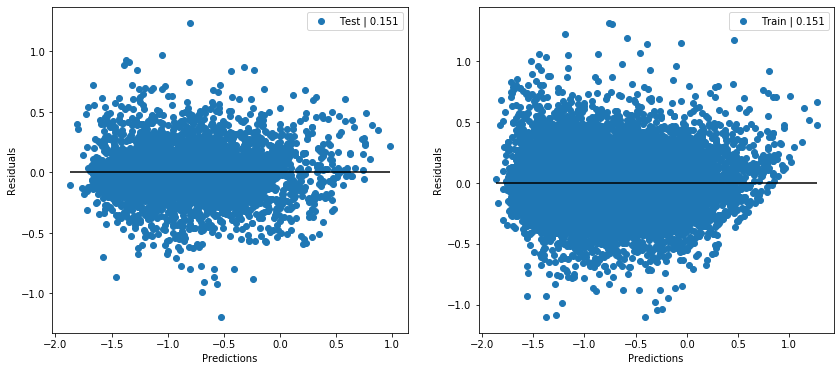

In [2]:
#plot residuals for train and test
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(prediction_test, residual_test, label = f'Test | {round(reg_mae,3)}')
ax[0].set_ylabel('Residuals')
ax[0].set_xlabel('Predictions')
ax[0].hlines(y=0, xmin = prediction_test.min(), xmax = prediction_test.max())
#ax[0].set_xlim(-2,2)
ax[0].legend()

ax[1].scatter(prediction_train, residual_train, label = f'Train | {round(reg_mae,3)}')
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel('Predictions')
ax[1].hlines(y=0, xmin = prediction_train.min(), xmax = prediction_train.max())
# ax[1].set_ylim(-1,1)
ax[1].legend()

### Test With Zillow

In [3]:
def predict_house_value(street, city, state, user_zipcode, living_sqft = 0, lot_sqft=0,
                     bedrooms=0, bathrooms=0, floors=0, waterfront = 0): 
    '''This function will calculate the cost of a house in King County WA given the parameters: 
    livig_sqft, lot_sqft, bedrooms, bathrooms, floors, street, city, state, zipcode'''
    address = f'{street}, {city}, {state} {user_zipcode}'
    price_chunk = 1000000
    
    df = pd.read_csv('data/updated_housing_data.csv')
    zip_one_hot = pd.get_dummies(df['zipcode'], prefix = 'zip')
    df = df.join(zip_one_hot)
    df['living_lot_ratio'] = round(df.sqft_living/df.sqft_lot, 4)
    living_lot_ratio = round(living_sqft / lot_sqft, 4)
    
    df.price = df.price.map(lambda x: x/price_chunk)
    df.waterfront.replace(np.nan, 0, inplace = True)
    cities = [f'city_{i}' for i in df.City.unique()]
    zipcodes = [f'zip_{zipc}' for zipc in df.zipcode.unique()]

    columns = ['sqft_living', 'living_lot_ratio', 'waterfront', 'bathrooms', 'floors', 'bedrooms'] + zipcodes + cities
    y = np.log(df[['price']])
    X = df[columns]
    X = sm.add_constant(X)
    linear = sm.OLS(y, X, hasconst = True).fit()
    #print(linear.summary())
    input_zip = [0 if f'zip_{user_zipcode}' != i else 1 for i in zipcodes]
    input_city = [0 if f'city_{city.lower()}' !=i else 1 for i in cities]
    input_predict = [[1, living_sqft, living_lot_ratio,waterfront, bathrooms, floors, bedrooms]
                     +input_zip+input_city] 
    house_predict = np.exp(linear.predict(input_predict)[0])
   
    house_predict_sum = np.exp(linear.get_prediction(input_predict).summary_frame(alpha = .05))
    return (abs(house_predict_sum['obs_ci_lower'].values[0]*price_chunk), 
            house_predict_sum['obs_ci_upper'].values[0]*price_chunk, house_predict*price_chunk, 
           house_predict/living_sqft*price_chunk)

In [4]:
#example houses from zillow.  Price is adjusted for inflation since 2015
house = dict(street = '10411 Maplewood Pl SW', city = 'Seattle', state = 'WA', zipcode = '98146', bedrooms = 3, 
            bathrooms = 4.5, floors = 3, living_sqft = 4070, lot_sqft = 22215.6, waterfront = 1, 
             actual_price = 3625000 * .92) 

# house = dict(street = '11115 34th Pl SW', city = 'Seattle', state = 'WA', zipcode = '98146', bedrooms = 4, 
#             bathrooms = 3, floors = 3, living_sqft = 2440, lot_sqft = 6969.6, 
#              actual_price = 609000 * .92, waterfront = 0) 

# house = dict(street = '30106 SE 26th St', city = 'Fall City', state = 'WA', zipcode = '98024', bedrooms = 4, 
#             bathrooms = 2.5, floors = 3, living_sqft = 4145, lot_sqft = 435600, 
#              actual_price = 1675000 * .92, waterfront = 0)

# house = dict(street = '3519 SW 108th St', city = 'Seattle', state = 'WA', zipcode = '98146', bedrooms = 5, 
#             bathrooms = 5, floors = 3, living_sqft = 3444, lot_sqft = 12632.4, 
#             actual_price = 1488000 * .92, waterfront = 0)

# house = dict(street = '30641 10th Ave S', city = 'Federal Way', state = 'WA', zipcode = '98003', bedrooms = 3, 
#         bathrooms = 2.25, floors = 1, living_sqft = 1394, lot_sqft = 9604, 
#         actual_price = 363000 * .92, waterfront = 0)


predict = predict_house_value(floors = house['floors'], bedrooms = house['bedrooms'], 
      bathrooms = house['bathrooms'], living_sqft = house['living_sqft'], lot_sqft = house['lot_sqft'], 
      street = house['street'], city = house['city'], state = house['state'], user_zipcode = house['zipcode'], 
         waterfront = house['waterfront'])

print(f'Price Prediction: ${round(predict[0],0)} - ${round(predict[1],0)}\n\
Predicted Price: ${round(predict[2], 0)} (${round(predict[3],2)} per sqft)\
\nActual Price: ${house["actual_price"]}')

Price Prediction: $1088686.0 - $2474927.0
Predicted Price: $1641468.0 ($403.31 per sqft)
Actual Price: $3335000.0
